In [1]:
sys.path.append('../')
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
pd.set_option('max_columns', None)
import os

In [2]:
%%capture
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [4]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [5]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

In [6]:

litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.3, .7], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [7]:
print(train.shape, litho_data.shape)

(388380, 9) (1294715, 9)


In [8]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (248563, 7) (248563,)
### Validation Dataset: ###  (62141, 7) (62141,)
### Test Dataset: ###  (77676, 7) (77676,)


In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [11]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

In [12]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"gamma":0.5, "step_size":75},
                       lambda_sparse=0.1,
                       n_steps=8,
                       n_shared=2,
                       n_independent=5,
                       n_a=32,
                       momentum=0.1,
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax')

Device used : cuda


In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)


In [14]:
max_epochs = 1000

clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs , patience=150,
    batch_size=2048,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 1.969   | train_balanced_accuracy: 0.54494 | valid_balanced_accuracy: 0.4915  |  0:00:57s
epoch 1  | loss: 1.34826 | train_balanced_accuracy: 0.60644 | valid_balanced_accuracy: 0.55039 |  0:01:54s
epoch 2  | loss: 1.22627 | train_balanced_accuracy: 0.6323  | valid_balanced_accuracy: 0.57497 |  0:02:52s
epoch 3  | loss: 1.13174 | train_balanced_accuracy: 0.65292 | valid_balanced_accuracy: 0.59097 |  0:03:49s
epoch 4  | loss: 1.08219 | train_balanced_accuracy: 0.67006 | valid_balanced_accuracy: 0.61603 |  0:04:46s
epoch 5  | loss: 1.04966 | train_balanced_accuracy: 0.6845  | valid_balanced_accuracy: 0.62655 |  0:05:44s
epoch 6  | loss: 1.01337 | train_balanced_accuracy: 0.69088 | valid_balanced_accuracy: 0.6284  |  0:06:41s
epoch 7  | loss: 0.98932 | train_balanced_accuracy: 0.697   | valid_balanced_accuracy: 0.62792 |  0:07:38s
epoch 8  | loss: 0.97045 | train_balanced_accuracy: 0.70291 | valid_balanced_accuracy: 0.63339 |  0:08:36s
epoch 9  | loss: 0.95072 | train_bala

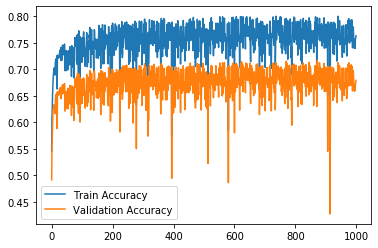

In [15]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

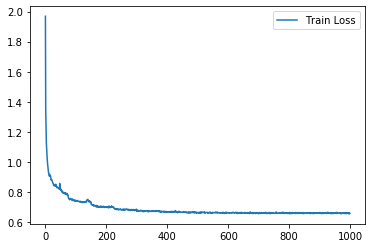

In [16]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()


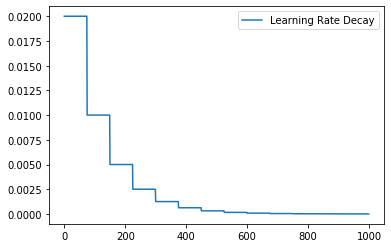

In [17]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()
